# AE (AutoEncoder) & Anomaly Detection

## 1. Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')  # mount your Google Drive to access datasets stored in your drive

Mounted at /content/drive/


In [2]:
# dataset for model training
!mkdir /content/drive/MyDrive/Colab\ Notebooks/data_3000  # create a folder for the uploaded data; you can change the file path if needed
!unzip -o /content/drive/MyDrive/Colab\ Notebooks/data_3000.zip -d /content/drive/MyDrive/Colab\ Notebooks/data_3000

Archive:  /content/drive/MyDrive/Colab Notebooks/data_3000.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/22.5651.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.119.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.149.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.2255.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.2919.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.3077.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.3701.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.388.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4496.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4706.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4709.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/data_3000/23.4904.jpg  
  inflating: /content/drive/

In [3]:
# dataset for anomaly detection
!mkdir /content/drive/MyDrive/Colab\ Notebooks/data_1000  # create a folder for the uploaded data; you can change the file path if needed
!unzip -o /content/drive/MyDrive/Colab\ Notebooks/data_1000.zip -d /content/drive/MyDrive/Colab\ Notebooks/data_1000

Archive:  /content/drive/MyDrive/Colab Notebooks/data_1000.zip
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4527.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4561.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4579.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4595.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4617.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4625.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4637.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4644.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4668.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4674.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4681.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_1000/35.4754.jpg  
 extracting: /content/dri

## 2. Import python libraries

In [4]:
import numpy as np  # library for numerical calculations
import pandas as pd  # data analysis library
import cv2 as cv  # computer vision library for image processing
import matplotlib.pyplot as plt  # visualization library for charts and plots
import os  # operating system library for file handling

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # model optimization
from torch.utils.data import DataLoader, TensorDataset  # dataset management
from torchsummary import summary  # model summary

import scipy.io
from sklearn.model_selection import train_test_split  # split data into training and testing sets
from sklearn.metrics import confusion_matrix  # confusion matrix

print(torch.__version__)      # check pytorch version

2.4.0+cu121


## 3. Convert images into trainable data & Split dataset

In [5]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = '/content/drive/MyDrive/Colab Notebooks/data_3000/'

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(1)  # Normal label: 1

X = np.array(X)
Y = np.array(Y)

# split the data into 80% training set and 20% test set (test set can be considered as validation)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

# reshape the (image,image) images into (image*image,) size vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 4. Set model hyperparameters

In [6]:
# model architecture parameters
image_size = np.shape(x_train[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

## 5. Set to model architecture

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

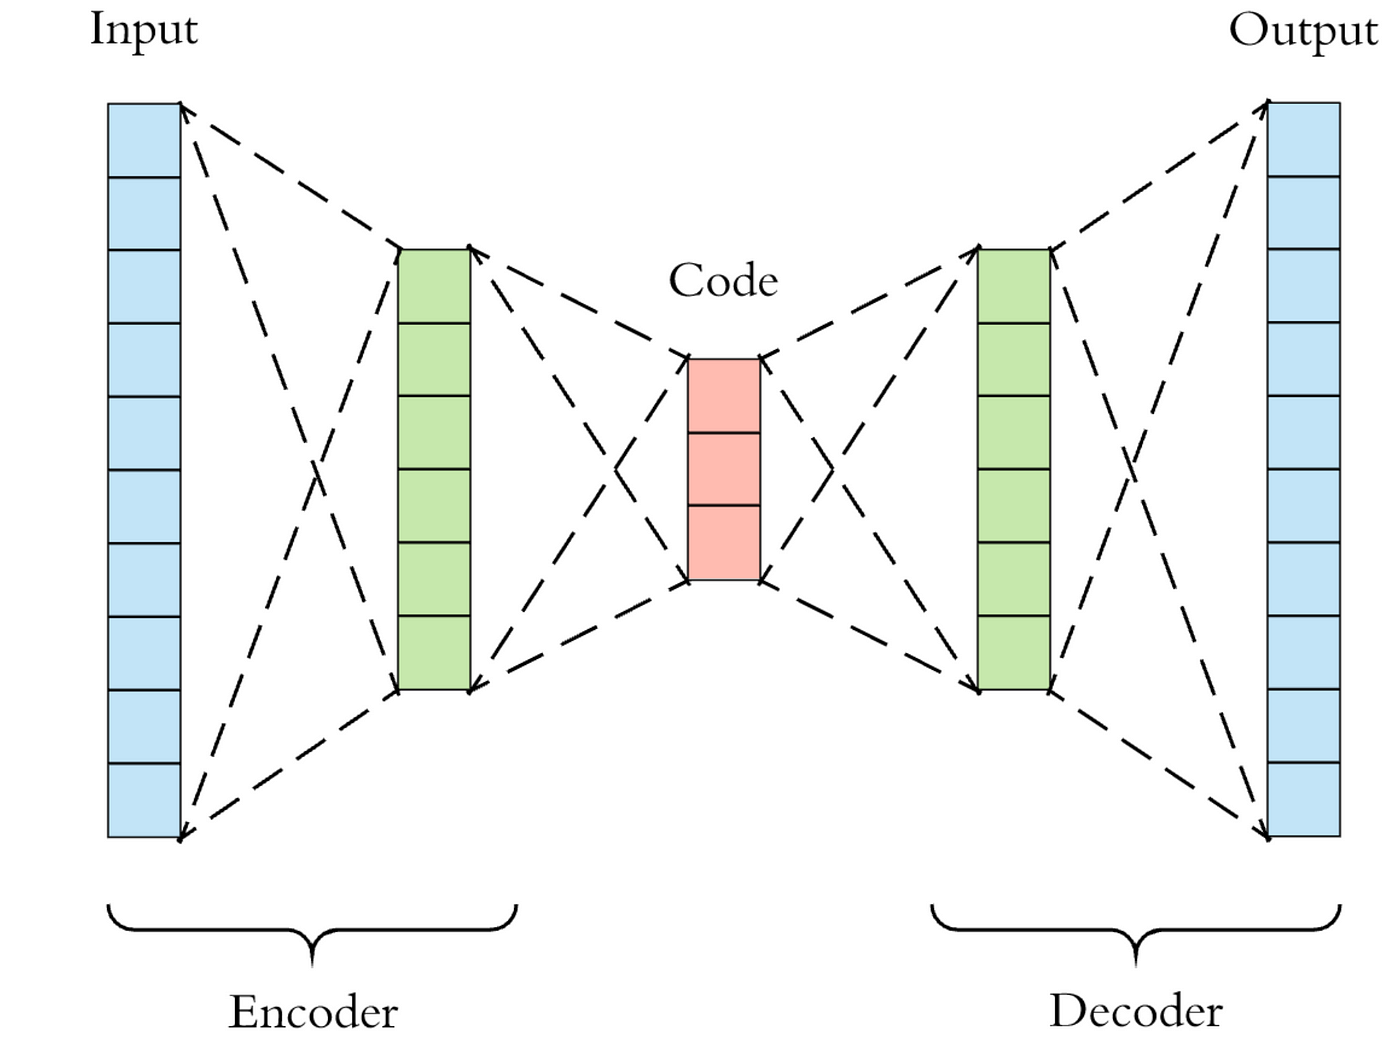

In [8]:
autoencoder = Autoencoder().to('cuda')

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 6. Train model

In [9]:
# set to loss function & optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [10]:
# convert data to PyTorch tensors
train_images = torch.tensor(x_train, dtype=torch.float32).to('cuda')
train_labels = torch.tensor(y_train, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(x_test, dtype=torch.float32).to('cuda')
test_labels = torch.tensor(y_test, dtype=torch.float32)   # don't need to use labels

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

# save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

Epoch [1/200], Train_loss: 0.1309339928130309
Epoch [2/200], Train_loss: 0.07071750179554025
Epoch [3/200], Train_loss: 0.061461250235637026
Epoch [4/200], Train_loss: 0.05662344557543596
Epoch [5/200], Train_loss: 0.050140723555038375
Epoch [6/200], Train_loss: 0.04567146621023615
Epoch [7/200], Train_loss: 0.043651744195570545
Epoch [8/200], Train_loss: 0.04221836297462384
Epoch [9/200], Train_loss: 0.039519838895648716
Epoch [10/200], Train_loss: 0.03838598377381762
Epoch [11/200], Train_loss: 0.03743022734609743
Epoch [12/200], Train_loss: 0.036391583550721404
Epoch [13/200], Train_loss: 0.03578257104381919
Epoch [14/200], Train_loss: 0.034860838251188395
Epoch [15/200], Train_loss: 0.034245077148079874
Epoch [16/200], Train_loss: 0.03357134995361169
Epoch [17/200], Train_loss: 0.032693866391976675
Epoch [18/200], Train_loss: 0.03198045697063208
Epoch [19/200], Train_loss: 0.03114986387081444
Epoch [20/200], Train_loss: 0.030647916983192167
Epoch [21/200], Train_loss: 0.03028929688

## 7. Load & Evaluate model

- Compare the orginial image and the reconstructed image / test dataset

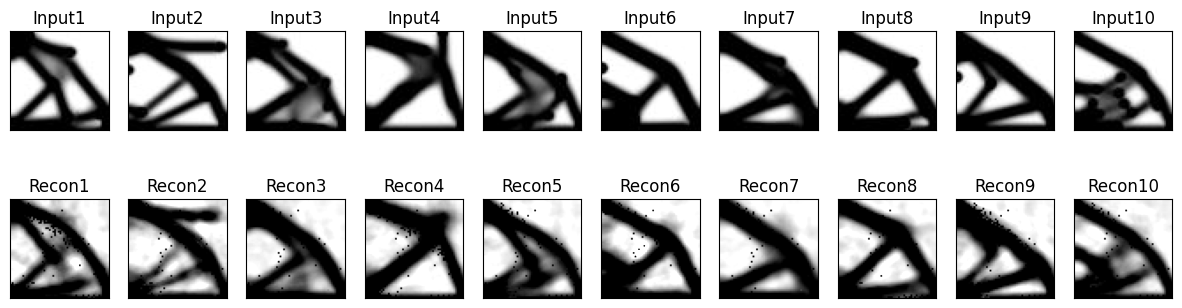

In [12]:
autoencoder.eval().to('cuda')

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 8. Anomaly detection test

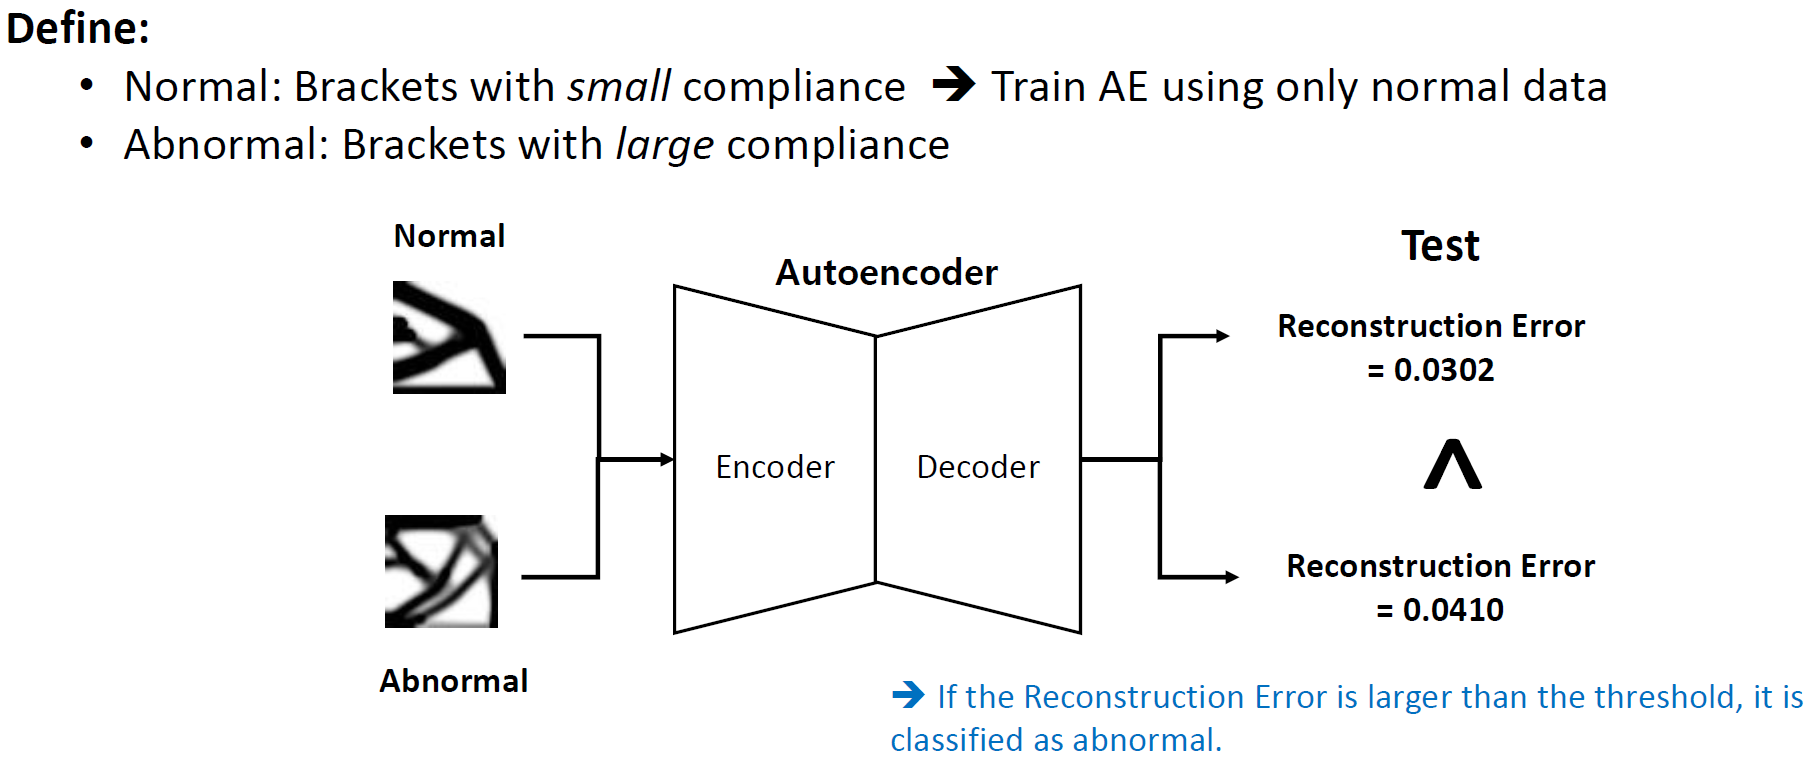

- Load abnormal dataset (data_1000.zip)

In [13]:
# image size = 56 x 56, 1000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src_anom = '/content/drive/MyDrive/Colab Notebooks/data_1000/'

anom_files = os.listdir(src_anom)  # get the list of files in the source directory

ANom,ANom_Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in anom_files:
    ANom.append(img_read(src_anom, file) / 255.)
    ANom_Y.append(0)  # abnormal label: 0

ANom = np.array(ANom)
ANom_Y = np.array(ANom_Y)

# reshape the (image,image) images into (image*image,) size vectors
ANom = ANom.reshape((len(ANom), np.prod(ANom.shape[1:]))).astype('float32')

print("Datasets_anomaly_shape:{}".format(np.shape(ANom)))

Datasets_anomaly_shape:(1000, 3136)


- Reconstruction of the test and anomaly data

In [14]:
# convert data to PyTorch tensors
ANom_images = torch.tensor(ANom, dtype=torch.float32).to('cuda')

autoencoder.eval()

reconstructed_test = autoencoder(test_images)
reconstructed_anom = autoencoder(ANom_images)

- Compare the orginial image and the reconstructed image / abnormal dataset

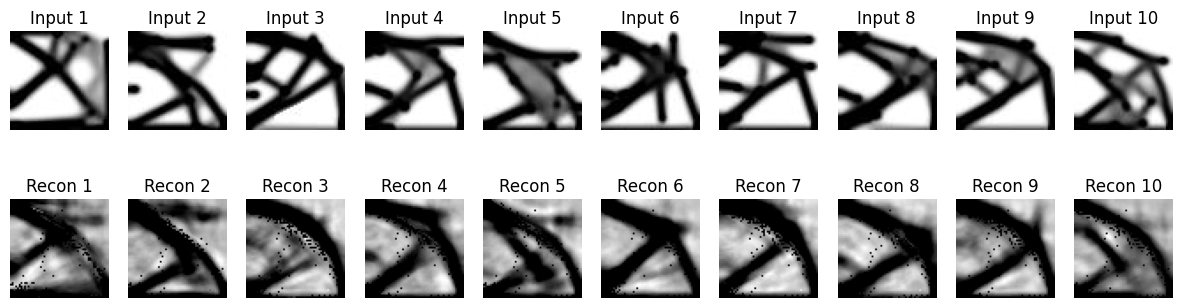

In [15]:
# proceed reconstruction of the bracket images through the trained autoencoder model

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(ANom_images.cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_anom.detach().cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

- Anomaly detection evaluation with metrics and confusion matrix

In [17]:
# calculate MSE for normal and abnormal data
mse_test = torch.mean((test_images - reconstructed_test) ** 2, dim=1).detach().cpu().numpy()
mse_anom = torch.mean((ANom_images - reconstructed_anom) ** 2, dim=1).detach().cpu().numpy()

# set threshold for anomaly detection
threshold = 0.05  # adjust this threshold based on data

# classify based on MSE
y_pred_test = np.where(mse_test > threshold, 0, 1)  # 0 = abnormal, 1 = normal
y_pred_anom = np.where(mse_anom > threshold, 0, 1)

# combine test and anomaly predictions and true labels
y_pred = np.concatenate((y_pred_test, y_pred_anom))
y_true = np.concatenate((y_test, ANom_Y))

In [18]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

TP = conf_mat[0][0]  # both are Anomaly, 0 and the predicted value is positive (abnormal)
FN = conf_mat[0][1]  # the actual and predicted values differ, and the predicted value is negative (normal)
FP = conf_mat[1][0]  # the actual and predicted values differ, and the predicted value is positive (abnormal)
TN = conf_mat[1][1]  # both are Normal, 1 and the predicted value is negative (normal)

accuracy = (TP + TN) / (TP + FN + FP + TN)
error_rate = (FP + FN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

[[978  22]
 [ 48 552]]
Accuracy: 95.62%
Error Rate: 4.38%
Precision: 95.32%
Recall: 97.80%


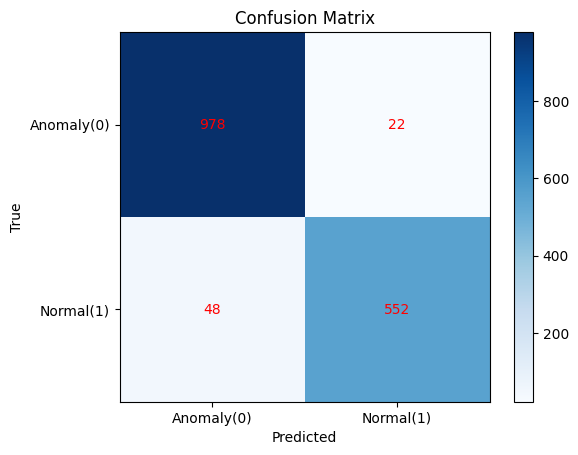

In [19]:
# plot confusion matrix
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.yticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_mat[i, j], ha="center", va="center", color="red")
plt.show()